# Buy it Again


## RCP - Repeat Customer Probability

- 상품 A를 2번 이상 고매한 고객의 수 / 상품 A를 최소 한번이라도 구매한 고객 수

In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load
import scipy.stats as stats
tqdm.pandas()


In [2]:
sample_folder = './h-and-m-personalized-fashion-recommendations/sampled_data/'
df = pd.read_csv(os.path.join(sample_folder, 'train_0.csv'))
valid_sample = pd.read_csv(os.path.join(sample_folder, 'valid_0.csv'))

folder = './h-and-m-personalized-fashion-recommendations/'
le_articles = load(os.path.join(folder, 'le_articles.joblib'))
le_customers = load(os.path.join(folder, 'le_customers.joblib'))



In [3]:
df['customer_id'] = le_customers.transform(df['customer_id'])
df['article_id'] = le_articles.transform(df['article_id'])

df['article_id'] = df['article_id'].astype(np.int32)
df['customer_id'] = df['customer_id'].astype(np.int32)
df['sales_channel_id'] = df['sales_channel_id'].astype('int8')
df['price'] = df['price'].astype('float32')

df['t_dat'] = pd.to_datetime(df['t_dat'])

In [4]:

## 동일상품 수량 2 이상 구매 합치기
df = df.groupby(['article_id', 'customer_id','t_dat'])
df_price = df.price.mean()
df_price = pd.DataFrame(df_price)
df_channel = df.sales_channel_id.max()

df = pd.merge(df_price,df_channel, left_index=True, right_index=True, how="left")
df = df.reset_index()
df['t_dat'] = pd.to_datetime(df['t_dat'])


In [5]:
grouped = df.groupby(['article_id', 'customer_id'])['t_dat'].count().reset_index()
grouped = grouped.rename(columns={'t_dat': 'cnt'})

grouped= grouped.sort_values('cnt', ascending= False)

denom = pd.DataFrame(grouped.groupby('article_id')['customer_id'].nunique()).reset_index()
denom = denom.rename(columns={'customer_id': 'denom_customer'})

numer = pd.DataFrame(grouped[grouped.cnt > 1].groupby('article_id')['customer_id'].nunique()).reset_index()
numer = numer.rename(columns={'customer_id': 'num_customer'})

rcp_df = pd.merge(denom, numer, on= 'article_id')
rcp_df['rcp'] = rcp_df['num_customer']/rcp_df['denom_customer']



<AxesSubplot:>

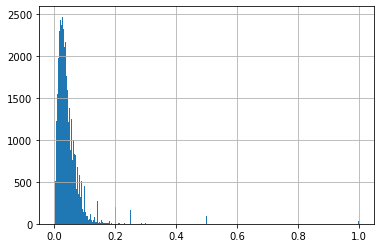

In [6]:
rcp_df = rcp_df.sort_values('rcp')

rcp_df['rcp'].hist(bins=500)


In [7]:
df = df.set_index(['customer_id', 'article_id'])
df = df.sort_values('t_dat')
df = df.sort_index()

df['shift_dat'] = df.groupby(level=[0,1])['t_dat'].shift(1)
df['dist'] = (df['t_dat'] - df['shift_dat']).dt.days
day_intervals = df.loc[df['dist'].notna(), 'dist'].values
df = df.reset_index()
df.head()

,customer_id,article_id,t_dat,price,sales_channel_id,shift_dat,dist
0,0,99,2018-12-27,0.035576,1,NaT,NaN
1,0,16003,2019-05-25,0.050831,2,NaT,NaN
2,0,16023,2020-09-05,0.050831,1,NaT,NaN
3,0,23996,2019-07-25,0.012695,1,NaT,NaN
4,0,29516,2018-12-27,0.044051,1,NaT,NaN


In [8]:


repeat_purchaseable = rcp_df[(rcp_df.rcp > rcp_df.rcp.quantile(q=0.75)) &
                             (rcp_df.num_customer > 30)].sort_values('rcp')


print(len(repeat_purchaseable))

tmp = df[df.article_id.isin(repeat_purchaseable.article_id.values)]

print("거래 비율", len(tmp)/len(df))
print("상품 비율", len(repeat_purchaseable)/len(df.article_id.unique()))
print("사용자 비율", (len(tmp.customer_id.unique())) / len(df.customer_id.unique()))

3311
거래 비율 0.2012995139429118
상품 비율 0.0318733153638814
사용자 비율 0.700296821204842


In [9]:
tmp= pd.merge(tmp, repeat_purchaseable[['article_id','rcp']], on='article_id' , how='left')



# Modified Poisson-Gamma Model (MPG)


- gamma: shape, rate = (1/scale)

- 논문에서는 제품-고객마다 감마분포를 피팅하는 것으로 파악되지만, 의류제품 특성상 2번이상의 재구매가 대부분 이루어지지 않아 제품마다 감마분포를 추정하는 것으로 변경 

- 감마 값 이상치 확인 필요: => $R_{A,C}$ 값이 너무 커져 최종 확률이 1보다 커짐
    - 감마사전분포 피팅된 알파값이 너무 큰 경우
    - t_purch가 작은 경우
    - |t_mean-t| 가 작은 경우


53
0.6510028578912692 0.9999999999999999 12.239398290697409


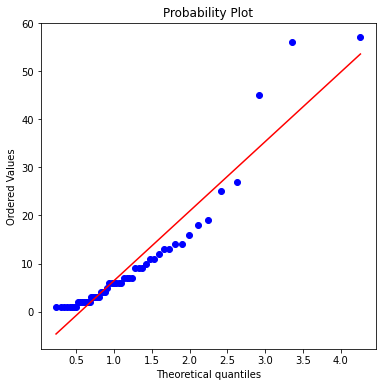

In [11]:
item_idx = 6
rp_items = repeat_purchaseable.article_id.values
cur_item = rp_items[item_idx]

# rp_customers = tmp[((tmp.article_id == cur_item) & (tmp.dist.notna()))].customer_id.unique()
# for i in range(len(rp_customers)):
#     cur_customer = rp_customers[i]
#     cur_df = tmp[(tmp.article_id == cur_item) & (tmp.customer_id == cur_customer)]
#     print(len(cur_df))


cur_df = tmp[(tmp.article_id == cur_item)]

cur_days = cur_df.dist.values
cur_days = cur_days[~np.isnan(cur_days)]
print(len(cur_days))
shape, loc, scale = stats.gamma.fit(cur_days)
print(shape, loc, scale)
plt.figure(figsize=(6,6))
stats.probplot(cur_days, dist=stats.lognorm, sparams=(shape,), plot=plt)
plt.show()

/Users/nys/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nys/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Density'>

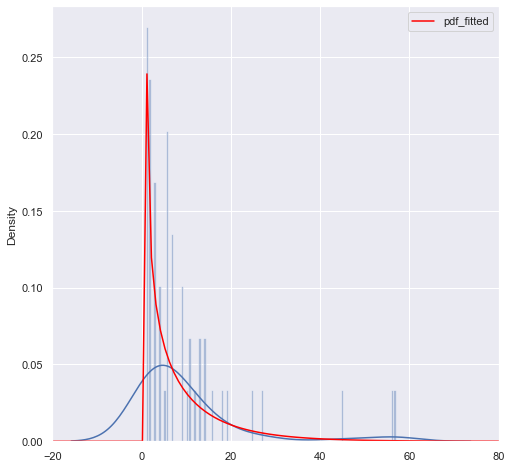

In [12]:
import seaborn as sns

def estimate_distribution(data, dist_name, x_size=100):
    dist = getattr(stats, dist_name)
    params = dist.fit(data)
    mean = params[-2]
    std = params[-1]
    n = data.shape[0]
    x = np.linspace(-20, 80, x_size)
    fitted_pdf = dist.pdf(x, *params[:-2], loc=mean, scale=std) 
    return x, params, fitted_pdf

sns.set(rc={'figure.figsize':(8,8)})
plt.xlim(-20,80)
x, params, fitted_pdf = estimate_distribution(cur_days, 'gamma')

# sns.distplot(dist, bins=30, norm_hist=False)
sns.distplot(cur_days, bins=100, norm_hist=False)
sns.lineplot(x, fitted_pdf, color='red', label='pdf_fitted')

In [13]:
rp_customers = tmp[((tmp.article_id == cur_item) & (tmp.dist.notna()))].customer_id.unique()
cur_df = cur_df[cur_df.customer_id.isin(rp_customers)]

$$\lambda_{A_{i},C_j} = {{k+\alpha_{A_i}}\over{t_{purch}+2|t_{mean}-t| + \beta_{A_i}}}$$

In [14]:
cur_customer = rp_customers[10]

cus_cur_df = cur_df[cur_df.customer_id == cur_customer]
cur_datetime = df.t_dat.max()

In [15]:


alpha = shape
beta = 1/scale
t_mean = cus_cur_df.dist.mean()
t_purch = ((cus_cur_df.t_dat.max() - cus_cur_df.t_dat.min()) / np.timedelta64(1, 'D'))
k = len(cus_cur_df)
cur_t = ((cur_datetime - cus_cur_df.t_dat.max())/ np.timedelta64(1, 'D'))

if cur_t > 2 * t_mean:
    gamma_art_cus = ((k + alpha)) / (cur_t + beta)
else:
    gamma_art_cus = (k + alpha) / (t_purch + (2 * abs(t_mean-cur_t)) +beta)
    
from math import factorial
large_r = 0.
for m in range(1,100):
    large_r += ((gamma_art_cus ** m) * np.exp(gamma_art_cus))/factorial(m)
    

In [16]:
large_r

0.003775733635410809

In [17]:
def calc_gamma(shape, scale, cus_cur_df, cur_datetime):
    alpha = shape
    beta = 1/scale
    t_mean = cus_cur_df.dist.mean()
    t_purch = ((cus_cur_df.t_dat.max() - cus_cur_df.t_dat.min()) / np.timedelta64(1, 'D'))
    k = len(cus_cur_df)
    cur_t = ((cur_datetime - cus_cur_df.t_dat.max())/ np.timedelta64(1, 'D'))
    in_t_mean = False
    if cur_t > 2 * t_mean:
        gamma_art_cus = ((k + alpha)) / (cur_t + beta)
    else:
        gamma_art_cus = (k + alpha) / (t_purch + (2 * abs(t_mean-cur_t)) +beta)
        in_t_mean = True
    return gamma_art_cus, in_t_mean, cus_cur_df.t_dat.max(), t_mean, k

def calc_large_r(gamma_art_cus, num_sum = 100):
    large_r = 0.
    for m in range(1,num_sum):
        large_r += ((gamma_art_cus ** m) * np.exp(gamma_art_cus))/factorial(m)
    return large_r


In [18]:
results = []

rp_items = repeat_purchaseable.article_id.values
cur_datetime = df.t_dat.max() + np.timedelta64(1, 'D') # 2020 9 16 기준

for cur_item in tqdm(rp_items):
    rp_customers = tmp[((tmp.article_id == cur_item) & (tmp.dist.notna()))].customer_id.unique()
    
    cur_df = tmp[(tmp.article_id == cur_item)]
    cur_days = cur_df.dist.values
    cur_days = cur_days[~np.isnan(cur_days)]

    shape, loc, scale = stats.gamma.fit(cur_days)

    for cur_customer in rp_customers:
        cus_cur_df = cur_df[cur_df.customer_id == cur_customer]
        gamma_art_cus, in_t_mean, last_buy_time, t_mean, k = calc_gamma(shape, scale, cus_cur_df, cur_datetime)
        large_r = calc_large_r(gamma_art_cus)
        
        results.append({"customer_id":cur_customer,
                         "article_id":cur_item,
                         "shape":shape, 
                         "loc":loc, 
                         "scale":scale,
                         "gamma":gamma_art_cus ,
                         "in_time": in_t_mean,
                         "last_buy_time": last_buy_time,
                         "large_r": large_r,
                         "mean_repeat_day":t_mean,
                         "num_purchases":k})        
        

100%|████████████████████████████████████████████████████████████| 3311/3311 [05:47<00:00,  9.54it/s]


In [19]:
mpg_df = pd.DataFrame(results)
mpg_df = pd.merge(mpg_df,
                  rcp_df[['article_id', 'rcp']],
                  on = 'article_id', how = 'left')

mpg_df['purchase_prob'] = mpg_df['rcp'] * mpg_df['large_r']

mpg_df['rank'] = mpg_df.groupby("customer_id")['purchase_prob'].rank("dense", ascending=False)
mpg_df = mpg_df.loc[mpg_df['rank'] <=12]

mpg_df['customer_id'] = le_customers.inverse_transform(mpg_df['customer_id'])
mpg_df['article_id'] = le_articles.inverse_transform(mpg_df['article_id'])

mpg_df['prediction'] = '0' + mpg_df['article_id'].astype(str) + ' '

In [20]:
mpg_df.purchase_prob.describe()

count    416200.000000
mean          0.001943
std           0.075752
min           0.000063
25%           0.000389
50%           0.000638
75%           0.001264
max          22.589621
Name: purchase_prob, dtype: float64

In [21]:
threshold = 0.05

print(len(mpg_df))
print(len(mpg_df[mpg_df.purchase_prob > threshold]))

from evaluate import mapk, apk

th_mpg_df = mpg_df[(mpg_df.purchase_prob > threshold)]
purchase_df = th_mpg_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()

merged= pd.merge(purchase_df, valid_sample, on='customer_id', how='inner')
merged['prediction'] = merged.prediction.fillna('')
print(len(merged))
mapk(
    merged['article_id'].map(lambda x: x.split()), 
    merged['prediction'].map(lambda x: x.split()), 
    k=12
)

416200
827
203


0.0687778559699742

In [22]:
threshold = 0.05

print(len(mpg_df))
print(len(mpg_df[mpg_df.purchase_prob > threshold]))

from evaluate import mapk, apk

th_mpg_df = mpg_df[(mpg_df.purchase_prob > threshold)]
purchase_df = th_mpg_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()

merged= pd.merge(purchase_df, valid_sample, on='customer_id', how='right')
merged['prediction'] = merged.prediction.fillna('')
print(len(merged))
mapk(
    merged['article_id'].map(lambda x: x.split()), 
    merged['prediction'].map(lambda x: x.split()), 
    k=12
)

416200
827
68984


0.00020239337762241626

In [23]:
def calc_map12(purchase_df, valid_sample, join_type= 'inner'):
    merged = pd.merge(purchase_df, valid_sample, on='customer_id', how=join_type)
    merged['prediction'] = merged.prediction.fillna('')
    return mapk(
        merged['article_id'].map(lambda x: x.split()), 
        merged['prediction'].map(lambda x: x.split()), 
        k=12
    )

In [24]:
mpg_df = mpg_df.sort_values('purchase_prob')

In [25]:
import math
probs = mpg_df.purchase_prob.unique()
probs = [math.ceil(p*10000)/10000.0 for p in probs]
probs = np.unique(probs)

In [26]:

map12_values = []
for p in tqdm(probs):
    threshold = p
    th_mpg_df = mpg_df[(mpg_df.purchase_prob >= threshold)]
    purchase_df = th_mpg_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    
    inner_map12 = calc_map12(purchase_df, valid_sample, 'inner')
    right_map12 = calc_map12(purchase_df, valid_sample, 'right')
    
    map12_values.append((threshold, inner_map12, right_map12))

100%|█████████████████████████████████████████████████████████████▉| 942/943 [02:14<00:00,  7.63it/s]/Users/nys/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nys/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████| 943/943 [02:14<00:00,  7.01it/s]


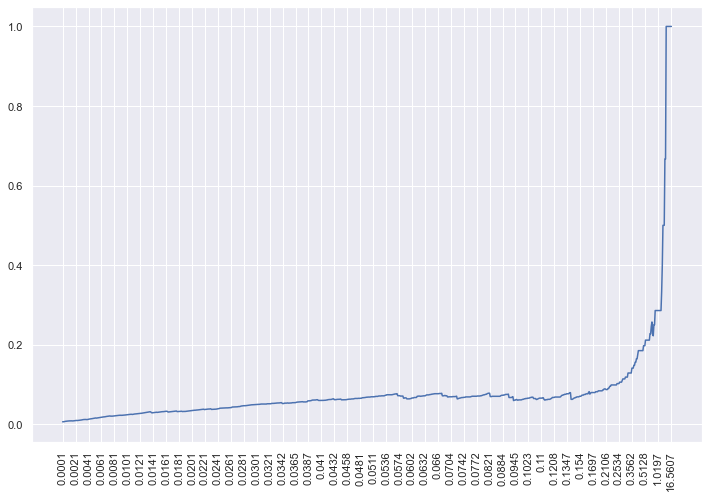

In [48]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
map12_values = np.array(map12_values)

x = list(map12_values[:,0])
xi = list(range(len(map12_values)))

x = [x[i] for i in range(0, len(x), 20)]
xi = [xi[i] for i in range(0, len(xi), 20)]
ax.set_xticks(xi,x)
plt.xticks(rotation = 90)
ax.plot(map12_values[:,1])
#ax.plot(map12_values[:,2])


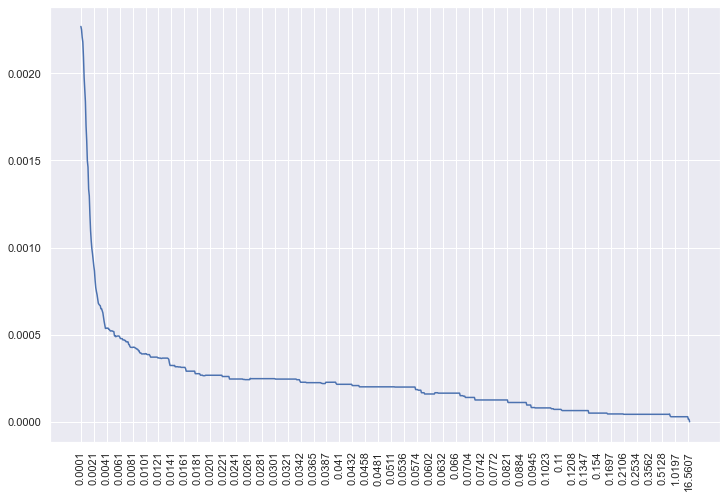

In [51]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xticks(xi,x)
plt.xticks(rotation = 90)
ax.plot(map12_values[:,2])



# References:
- buy it agiain paper: https://dl.acm.org/doi/pdf/10.1145/3219819.3219891
- sns.distplot.kde : https://darkpgmr.tistory.com/147
- lognormal의 파라미터
https://stackoverflow.com/questions/8747761/scipy-lognormal-distribution-parameters
- 확률분포 mle fitting 이 후, 시각화  http://incredible.ai/statistics/2015/06/13/Distribution-Estimation/
- scipy의 lognormal plot, 표준편차가 너무 클 때: https://stats.stackexchange.com/questions/239081/normal-qq-plot-of-logarithm-of-data-does-not-match-log-normal-qq-plot-of-data-it


# Kaggle - Trending Products Weekly

- https://www.kaggle.com/code/byfone/h-m-trending-products-weekly
- https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook
- https://www.kaggle.com/code/byfone/h-m-purchases-in-a-row/notebook




In [18]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load


tqdm.pandas()


In [19]:
sample_folder = './h-and-m-personalized-fashion-recommendations/sampled_data/'
df = pd.read_csv(os.path.join(sample_folder, 'train_0.csv'))
valid_sample = pd.read_csv(os.path.join(sample_folder, 'valid_0.csv'))

folder = './h-and-m-personalized-fashion-recommendations/'
le_articles = load(os.path.join(folder, 'le_articles.joblib'))
le_customers = load(os.path.join(folder, 'le_customers.joblib'))



In [20]:
df['customer_id'] = le_customers.transform(df['customer_id'])
df['article_id'] = le_articles.transform(df['article_id'])

df['article_id'] = df['article_id'].astype(np.int32)
df['customer_id'] = df['customer_id'].astype(np.int32)
df['sales_channel_id'] = df['sales_channel_id'].astype('int8')
df['price'] = df['price'].astype('float32')

df['t_dat'] = pd.to_datetime(df['t_dat'])

In [23]:
gb = df.groupby(['customer_id', 'article_id'])['t_dat'].nunique()
inx = gb[gb>1].index

df = df.set_index(['customer_id', 'article_id'])
df = df.loc[inx].copy().sort_index()

df['shift_dat'] = df.groupby(level=[0,1])['t_dat'].shift(1)
df['dist'] = (df['t_dat'] - df['shift_dat']).dt.days
dist = df.loc[df['dist'].notna(), 'dist'].values
vc = df['dist'].value_counts()
vc = vc[1:]

/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_29792/917143793.py:2: RuntimeWarning: overflow encountered in exp
  return a / np.sqrt(x) + b * np.exp(-c*x) + d


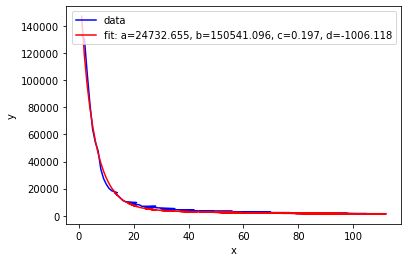

In [25]:
def func(x, a, b, c, d):
    return a / np.sqrt(x) + b * np.exp(-c*x) + d
# vc.index : 재구매 일수
# vc.values : 재구매 일수 별 횟수
popt, pcov = curve_fit(func, vc.index, vc.values)

plt.plot(vc.index[:100], vc.values[:100], 'b-', label='data')
plt.plot(vc.index[:100], func(vc.index[:100], *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [26]:
df = df.reset_index()


In [27]:
N = 12

last_ts = df['t_dat'].max()

tmp = df[['t_dat']].copy()
tmp['dow'] = tmp['t_dat'].dt.dayofweek
#  Monday=0, Sunday=6

In [28]:
last_ts

Timestamp('2020-09-15 00:00:00')

In [29]:
tmp.head()

,t_dat,dow
0,2019-05-07,1
1,2019-06-18,1
2,2020-04-22,2
3,2018-09-21,4
4,2018-09-27,3


In [31]:
df.head()

,customer_id,article_id,t_dat,price,sales_channel_id,week_num,shift_dat,dist
0,1,1469,2019-05-07,0.022017,2,72,NaT,NaN
1,1,1469,2019-06-18,0.022017,2,66,2019-05-07,42.0
2,1,1469,2020-04-22,0.016932,2,21,2019-06-18,309.0
3,1,19333,2018-09-21,0.067780,2,104,NaT,NaN
4,1,19333,2018-09-27,0.067780,2,103,2018-09-21,6.0


In [32]:
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
tmp.loc[tmp['dow'] >=2 , 'ldbw'] + 
pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + \
        pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')


In [44]:
df['ldbw'] = tmp['ldbw'].values
# lbdw: 마지막 날짜인 화요일이기 때문에, 이번주 수~ 다음주 월요일 -> 다음주 화요일(1)의 날짜로 설정

In [45]:

weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})



In [48]:
weekly_sales = weekly_sales[['ldbw', 'article_id', 'count']]
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')


In [49]:
df.head()

,customer_id,article_id,t_dat,price,sales_channel_id,week_num,shift_dat,dist,ldbw,count
0,1,1469,2019-05-07,0.022017,2,72,NaT,NaN,2019-05-07,52
1,1,1469,2019-06-18,0.022017,2,66,2019-05-07,42.0,2019-06-18,67
2,1,1469,2020-04-22,0.016932,2,21,2019-06-18,309.0,2020-04-28,86
3,1,19333,2018-09-21,0.067780,2,104,NaT,NaN,2018-09-25,6
4,1,19333,2018-09-27,0.067780,2,103,2018-09-21,6.0,2018-10-02,6


In [51]:
weekly_sales = weekly_sales.reset_index().set_index('article_id')

In [54]:
df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
    on='article_id', suffixes=("", "_targ"))


In [56]:
# count: 이번 주에 해당 물품 팔린 횟수 
# count_targ: 마지막 주에 해당 물품 팔린 횟수
# quotient = count_targ / count

df['count_targ'].fillna(0, inplace=True)
del weekly_sales; gc.collect();
df['quotient'] = df['count_targ'] / df['count']

# target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
# general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
# general_pred = ['0' + str(article_id) for article_id in general_pred]
# general_pred_str =  ' '.join(general_pred)
# del target_sales

In [64]:
purchase_dict = {}

# x : 마지막 날짜와 거래날짜의 차이 최소 1이 되도록
tmp = df.copy()
tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)



In [65]:
# 아래 식:  f(전체 재구매 상품에 대한 재구매 기간) = 재구매 횟수
#         함수 f를 fitting
# quotient = 마지막 주에 해당 물품 팔린 횟수 / 해당 주에 해당 물품 팔린 횟수 
# value = 해당 상품 예상 재구매 횟수 * 마지막주에 해당상품 팔린 횟수 / 해당 주에 해당 물품 팔린 횟수 
a, b, c, d = popt
tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d
tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
tmp['value'] = tmp['quotient'] * tmp['y'] 


In [71]:
tmp.value.describe()

count    2.931440e+05
mean     1.269612e+04
std      4.108054e+04
min      2.239681e+01
25%      1.108353e+03
50%      3.097917e+03
75%      7.514277e+03
max      6.975934e+06
Name: value, dtype: float64

In [69]:
tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
tmp = tmp.reset_index()

In [74]:

tmp = tmp.loc[tmp['value'] > 100]
tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]

purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)



/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_29792/528567860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)


In [75]:
purchase_df['customer_id'] = le_customers.inverse_transform(purchase_df['customer_id'])
purchase_df['article_id'] = le_articles.inverse_transform(purchase_df['article_id'])

In [76]:
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()

In [77]:
from evaluate import mapk, apk

In [78]:
merged= pd.merge(purchase_df, valid_sample, on='customer_id', how='inner')

mapk(
    merged['article_id'].map(lambda x: x.split()), 
    merged['prediction'].map(lambda x: x.split()), 
    k=12
)

0.013376533261544206

In [79]:
df.head()

,customer_id,article_id,t_dat,price,sales_channel_id,week_num,shift_dat,dist,ldbw,count,count_targ,quotient
0,1,1469,2019-05-07,0.022017,2,72,NaT,NaN,2019-05-07,52,4,0.076923
1,1,1469,2019-06-18,0.022017,2,66,2019-05-07,42.0,2019-06-18,67,4,0.059701
2,1,1469,2020-04-22,0.016932,2,21,2019-06-18,309.0,2020-04-28,86,4,0.046512
3,6201,1469,2019-01-14,0.022017,2,88,NaT,NaN,2019-01-15,47,4,0.085106
4,6201,1469,2020-05-08,0.018712,2,19,2019-01-14,480.0,2020-05-12,51,4,0.078431
